# Mean Reversion - Using Bollinger Bands

A mean reversal strategy assumes that the price of a stock will revert back to its mean. This means we can long the stock, buy low, in order to exit the position for a profit. Similarly, we can short a position, sell high annd exit a position low for a profit. 

To begin this strategy we import all the neccessary libraries

In [3]:
import bt
import yfinance as yf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

We use Yahoo Finance to download the historical stock data in daily intervals from the start of 2017 to the end of September 2024 for Apple and Meta. We combine the two stocks Adjusted Closing prices, to align them with the right dates.

In [223]:
# Load Apple and Meta Stock prices in daily intervals for [01-01-2017 to 30-09-2024]
aapl_data = yf.download(tickers = 'AAPL', start = '2017-01-01', end ='2024-09-30', interval = '1d')
meta_data = yf.download(tickers = 'META', start = '2017-01-01', end ='2024-09-30', interval = '1d')
backtest_data = aapl_data.copy()
backtest_data['Open'] = aapl_data['Adj Close']
backtest_data['High'] = meta_data['Adj Close']
backtest_data = backtest_data.drop(['Low','Close','Adj Close','Volume'], axis = 1)
backtest_data = backtest_data.rename(columns = {'Open' : 'AAPL', 'High' : 'META'})
backtest_data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AAPL,META
Date,,
2017-01-03,26.921543,116.509201
2017-01-04,26.891415,118.333710
2017-01-05,27.028164,120.307770
2017-01-06,27.329485,123.039551
2017-01-09,27.579809,124.525070
...,...,...
2024-09-23,226.470001,564.409973
2024-09-24,227.369995,563.330017
2024-09-25,226.369995,568.309998


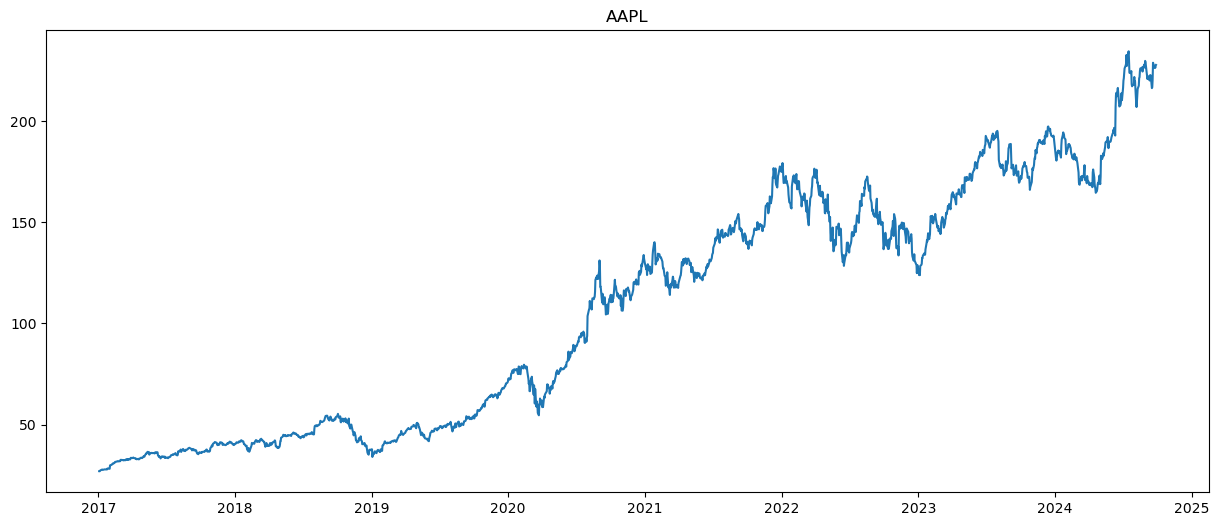

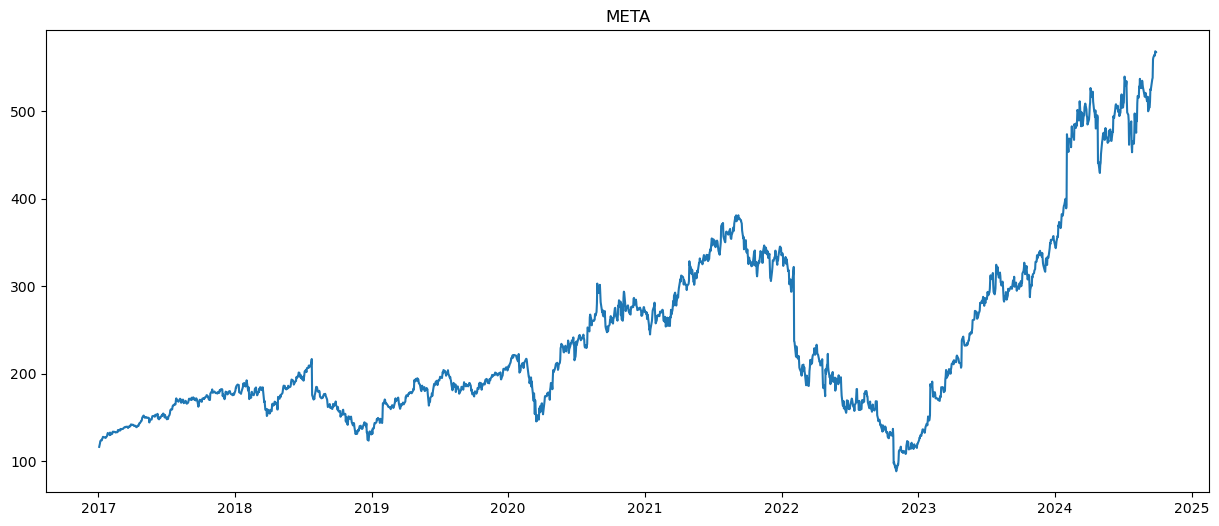

In [224]:
# Plot to see the rough trend in prices.
plt.figure(figsize = (15,6))
plt.plot(backtest_data['AAPL'])
plt.title('AAPL')
plt.show()
plt.figure(figsize = (15,6))
plt.plot(backtest_data['META'])
plt.title('META')
plt.show()

## Strategy

We need to identify 4 seperate codnitions which will idicate what position we hold in each stock. Thes conditions are the entry and exit points of a long and the entry and exit of a short. 

Our long entry is determined by identifying when the price of the stock tags the lower Bollinger band. This band is 2 standard deviations below the Simple Moving Average, and so we are buying and 'hoping' it increases back to the moving average. 

Ou short follows the same logic. We enter into a short position when the price tags the Upper Bollinger band. This is 2 standard deviations above the SMA and so we are hoping it decreases back to this level. 

Our exit positions for both long ad short are executed by setting the weight of the stock to 0 when the price falls in the range of 1 std deviation either side of the SMA, a 'stable zone'.

100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


<Axes: title={'center': 'Equity Progression'}>

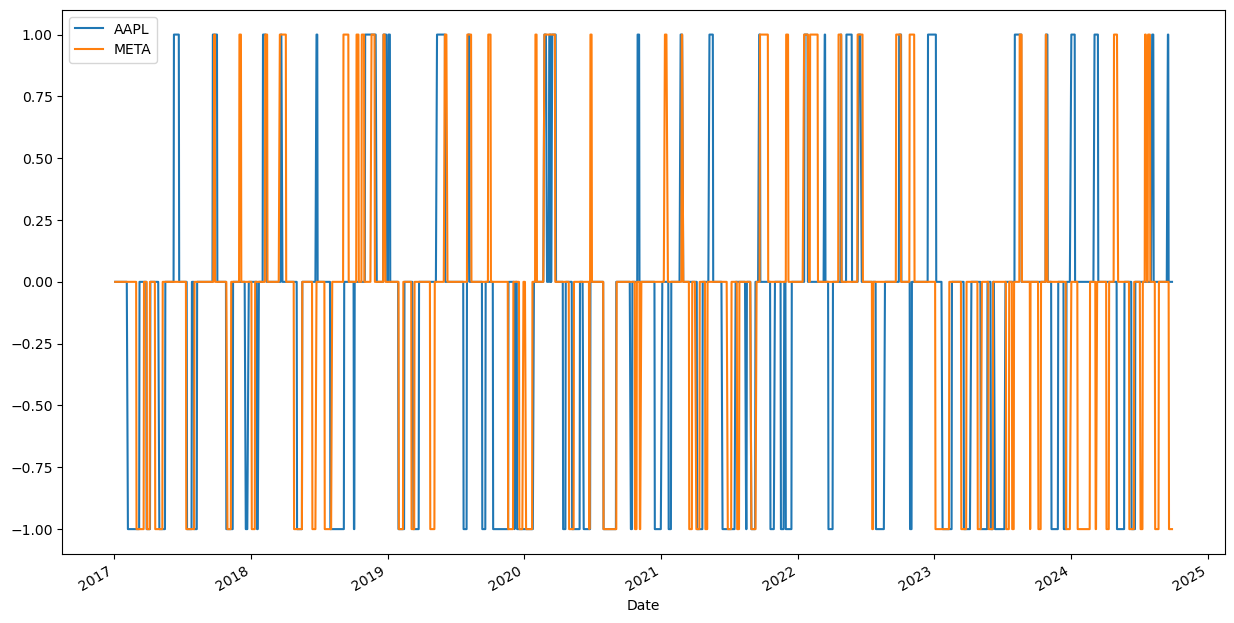

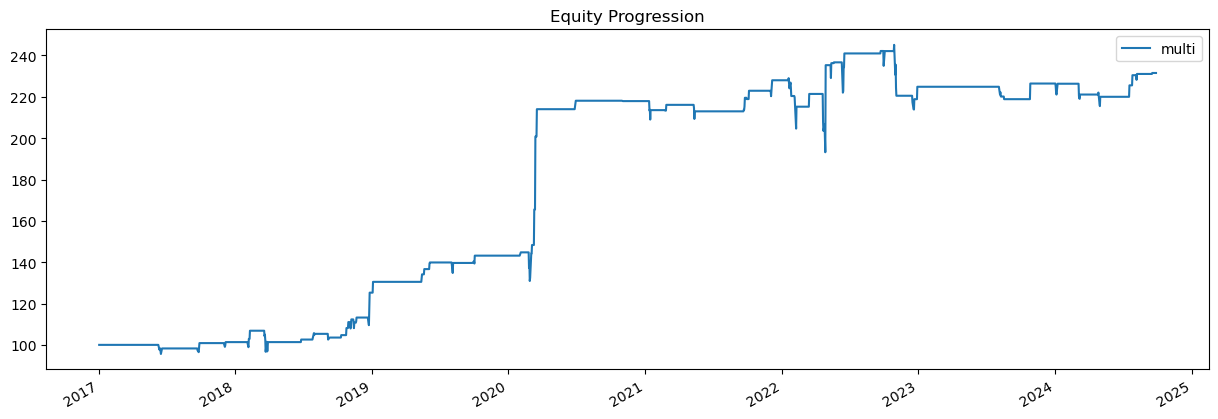

In [258]:
# Set the Moveing Averge window
window = 24

# Calculate the SMA with this Widnow
sma = backtest_data.rolling(window).mean()

# Calculate the Upper and Lower Bollinger bands
upper_boll_1 = sma + 2*backtest_data.rolling(window=window).std()
lower_boll_1 = sma - 2*backtest_data.rolling(window=window).std()
upper_boll_2 = sma + 1*backtest_data.rolling(window=window).std()
lower_boll_2 = sma - 1*backtest_data.rolling(window=window).std()


# Copy the structure of the stock data, mainly the date column
signal = backtest_data.copy()

# Set values in df to NaN
signal[:] = np.nan

# Buy signal when the price drops below the 2std lower bollinger line 
buy_condition = ((backtest_data < lower_boll_1))
signal[buy_condition] = True  # Buy signal (True)



# Sell signal when the price is above the 2std upper Bollinger line
sell_condition = ((backtest_data > upper_boll_1))
signal[sell_condition] = False

# Create the Weight allocation class 
class WeighTarget(bt.Algo):
    
    def __init__(self, target_weights, signal):
        self.tw = target_weights
        self.signal = signal
    
    def __call__(self, target):
        if target.now in self.tw.index:
            w = self.tw.loc[target.now]
            w = w.where(self.signal.loc[target.now], other=0)
            
            target.temp['weights'] = w.dropna()
    
        return True


# Produce the target weight df 
tw = backtest_data.copy()

# Set inital weights to 0
tw[:] = 0.0

# Outline the conditions of the outside bands by negating the condition that is inside
outside_bands = ~((backtest_data < upper_boll_2) & (backtest_data > lower_boll_2))

# Set-up a df that will keep track if we are entered into a position or not
in_pos = tw.copy()
in_pos[:] = np.nan

# Sets to True when the buy(long) or sell(short) condition is true
in_pos[buy_condition | sell_condition] = True

# We forward fill the df to 'hold' the position 
in_pos.ffill(inplace = True)

# We exit out of positionby setting to false when not outside (inside) the stable zone
in_pos[~((outside_bands))] = False

# Set weight to 1.0 (long position) when the price is below the Lower bollinger line
tw[((backtest_data < lower_boll_1))] = 1.0

# Set weight to -1.0 (short) when price is above the Upper bollinger line
tw[((backtest_data > upper_boll_1))] = -1.0

# Now we need to iterate through rows to propagate holding positions
for i in range(1, len(tw)):
    # Loops through each ticker ('AAPL', 'META')
    for col in tw.columns:
        # Use .loc to access rows/columns using label-based indexing
        if tw.loc[tw.index[i-1], col] == 1.0 and outside_bands.loc[tw.index[i], col] and in_pos.loc[tw.index[i], col]:
            # If the previous row had a long position and the price is still outside bands and we're in position
            tw.loc[tw.index[i], col] = 1.0  # Hold long position
        elif tw.loc[tw.index[i-1], col] == -1.0 and outside_bands.loc[tw.index[i], col] and in_pos.loc[tw.index[i], col]:
            # If the previous row had a short position and the price is still outside bands and we're in position
            tw.loc[tw.index[i], col] = -1.0  # Hold short position
        
            
# Plot the weighting of the stocks
ax = tw.plot(figsize = (15,8), secondary_y = ['tw'], legend = True)

# Produce the Strategy
s = bt.Strategy('multi', [bt.algos.RunDaily(),             # Run Daily
                          bt.algos.SelectAll(),            # Select all stocks
                          WeighTarget(tw,signal),          # Weight allocation
                          bt.algos.Rebalance()])           # Rebalance


# now we create the Backtest
t = bt.Backtest(s, backtest_data, initial_capital = 1000)

# Run the Backtest
res = bt.run(t)

# Plot the Backtest
res.plot()

In [254]:
# Display stats of Backtest
res.display()

Stat                 multi
-------------------  ----------
Start                2017-01-02
End                  2024-09-27
Risk-free rate       0.00%

Total Return         131.54%
Daily Sharpe         0.72
Daily Sortino        1.61
CAGR                 11.47%
Max Drawdown         -15.64%
Calmar Ratio         0.73

MTD                  0.20%
3m                   5.24%
6m                   4.72%
YTD                  2.25%
1Y                   5.79%
3Y (ann.)            1.79%
5Y (ann.)            10.64%
10Y (ann.)           -
Since Incep. (ann.)  11.47%

Daily Sharpe         0.72
Daily Sortino        1.61
Daily Mean (ann.)    12.22%
Daily Vol (ann.)     16.98%
Daily Skew           10.30
Daily Kurt           198.27
Best Day             21.80%
Worst Day            -6.33%

Monthly Sharpe       0.55
Monthly Sortino      3.04
Monthly Mean (ann.)  13.07%
Monthly Vol (ann.)   23.59%
Monthly Skew         7.87
Monthly Kurt         70.10
Best Month           61.58%
Worst Month          -7.48%

Year

As we can see we made 131% return over the 7 years. We had an annual Sharpe ratio of 0.72.

We can play around with the window of the bollinger bands and the size of the 'stable zone'.
